In [176]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.algorithms.optimizers import L_BFGS_B, GradientDescent, COBYLA
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.opflow import Z, X, I, PauliSumOp, MatrixOp

from surfer.qfi import ReverseQFI
from surfer.gradient import ReverseGradient

In [177]:
n = 5
ansatz = RealAmplitudes(n, reps=2)
# ansatz.entanglement_blocks = "cz"
# th = Parameter("th")
# ansatz = QuantumCircuit(2)
# ansatz.h(0)
# ansatz.ry(th, 1)
H = SparsePauliOp.from_sparse_list([
    ("ZZ", [i, i + 1], 1) for i in range(n - 1)
] + [
    ("X", [i], 1) for i in range(n)
], num_qubits=n)

In [178]:
def energy(values):
    return Statevector(ansatz.bind_parameters(values)).expectation_value(H).real

In [179]:
def fidelity(values1, values2):
    circuit1 = ansatz.bind_parameters(values1)
    circuit2 = ansatz.bind_parameters(values2)
    
    inner = np.conj(Statevector(circuit1)).T.dot(Statevector(circuit2))
    return np.clip(np.abs(inner) ** 2, 0, 1)

In [180]:
def metric(values1, values2, qgt=None):
    if qgt is None:
        qgt = ReverseQFI().compute(ansatz, values2) / 4
    return (values2 - values1).dot(qgt.dot(values2 - values1))

In [181]:
def mclachlan(theta, dt):
    energy_gradient = -0.5 * ReverseGradient().compute(H, ansatz, theta)
    qgt = ReverseQFI().compute(ansatz, theta) / 4
    dtheta = COBYLA().minimize(lambda x: x.T.dot(qgt.dot(x)) - 2 * x.T.dot(energy_gradient), x0=np.zeros_like(theta)).x
#     dtheta = (qgt, -0.5 * energy_gradient, rcond=-1)[0]
    return theta + dt * dtheta

In [182]:
optimizer = COBYLA()
# optimizer = GradientDescent(maxiter=100, learning_rate=0.01)

def dual(theta, dt):
    energy_gradient = 0.5 * ReverseGradient().compute(H, ansatz, theta)
    qgt = ReverseQFI().compute(ansatz, theta) / 4
    
    def loss(next_theta):
        diff = next_theta - theta
        infid = 1 - fidelity(theta, next_theta)
        met = metric(theta, next_theta, qgt=qgt)
        if np.abs(infid - met) > 0.1:
            print("-- large error:", np.abs(infid - met))
            
        return np.dot(diff, energy_gradient) + 0.5 / dt * infid * (1 + np.linalg.norm(diff))
    
    result = optimizer.minimize(loss, theta)
    print(result.fun)
    return result.x

In [183]:
def infidelity_derivative(theta, delta_theta):
    omega = ParameterVector("omega", ansatz.num_parameters)    

    circuit = ansatz.compose(ansatz.bind_parameters(theta).inverse())
    proj = MatrixOp(np.diag([1] + [0] * (2 ** ansatz.num_qubits - 1)))
    
    grad = -ReverseGradient().compute(proj, circuit, theta + delta_theta)            
    return grad

In [189]:
def sgd_dual(
    theta, 
    dt, 
    maxiter=100, 
    learning_rate=0.01, 
    gradtol=1e-2, 
    losstol=1e-4, 
    return_history=False, 
    x0=None, 
    norm_factor=1,
    arccos=False,
):
    energy_gradient = 0.5 * ReverseGradient().compute(H, ansatz, theta)
    qgt = ReverseQFI().compute(ansatz, theta) / 4
    losses = []  # loss value
    gnorms = []  # norm of gradient
    thetas = []  # current theta value
    
    if not hasattr(learning_rate, "__iter__"):
        learning_rate = np.ones(maxiter) * learning_rate
        
    eta = iter(learning_rate)
    
    if x0 is None:
        x = np.zeros_like(theta)
    else:
        x = x0
        
    if arccos:
        infid = np.arccos(np.sqrt(fidelity(theta, theta + x))) ** 2
    else:
        infid = 1 - fidelity(theta, theta + x)

    loss = np.dot(x, energy_gradient) + 0.5 / dt * infid * (1 + norm_factor * np.linalg.norm(x) ** 2)
    losses.append(loss)
        
    for i in range(maxiter):
        # compute loss
        fid = fidelity(theta, theta + x)
        if arccos:
            infid = np.arccos(np.sqrt(fid)) ** 2
        else:
            infid = 1 - fid
            
        x_norm = np.linalg.norm(x)    
        met = metric(theta, theta + x, qgt=qgt)
        if np.abs(infid - met) > 0.1:
            print("-- large error:", np.abs(infid - met))

        # compute gradient
        infid_derivative = infidelity_derivative(theta, x)
        
        if arccos:
            if np.isclose(fid, 1):
                infid_derivative = infid_derivative * np.sqrt(2)
            else:
                infid_derivative = infid_derivative * np.arccos(np.sqrt(fid)) / np.sqrt(2 * fid * (1 - fid))

                    
        d1 = infid_derivative * (1 + norm_factor * x_norm ** 2)
        d2 = 2 * norm_factor * x * infid 
        gradient = energy_gradient + 0.5 / dt * (d1 + d2)
        
        # update iterate
        x = x - next(eta) * gradient
        
        loss = np.dot(x, energy_gradient) + 0.5 / dt * infid * (1 + norm_factor * x_norm ** 2)
        losses.append(loss)
                
        if return_history:
            gnorms.append(np.linalg.norm(gradient))
            thetas.append(theta + x)
        
        if np.abs(losses[-1] - losses[-2]) < losstol:
            print("-- Reached losstol.")
            break
        
        if np.linalg.norm(gradient) < gradtol:
            print("-- Reached tolerance.")
            break
        
    if return_history:
        return theta + x, losses, gnorms, thetas
    
    return theta + x

## Single step optimization

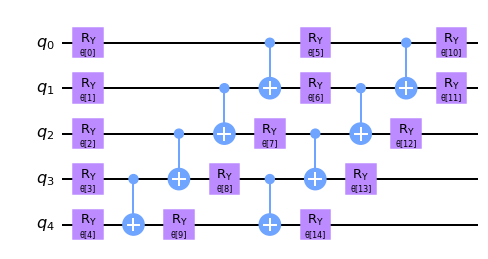

In [185]:
ansatz.decompose().draw("mpl")

In [186]:
np.random.seed(5)
theta = np.random.random(ansatz.num_parameters)
dt = 0.01

In [187]:
varqite = mclachlan(theta, dt)

In [740]:
direct = dual(theta, dt)

-0.02806441853053911


In [741]:
fidelity(varqite, direct)

0.9999941703725282

In [188]:
duality, losses, gnorms, thetas = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=1000, norm_factor=0, losstol=0, gradtol=0,
    arccos=False
)

[ 2.77555756e-17  5.46437895e-17  9.10729825e-18 -8.26721399e-17
  3.75918226e-17 -0.00000000e+00  3.67544536e-17 -0.00000000e+00
  1.58543543e-17 -4.07258426e-17  5.55111512e-17  2.60208521e-18
 -0.00000000e+00  6.93737933e-18  2.82975478e-17]
[-0.00276227  0.00779216 -0.00063397 -0.00023981  0.00052054 -0.00364302
  0.00335172 -0.00252181 -0.00111533  0.00120202 -0.00366047  0.00736466
 -0.00513967 -0.00052899  0.00061095]
[-0.004025    0.01176619 -0.00077916 -0.00015551  0.00060014 -0.00566617
  0.00471032 -0.0033374  -0.00173815  0.00176223 -0.00577846  0.01091463
 -0.00741456 -0.00023859  0.00067317]
[-4.54897972e-03  1.38914605e-02 -7.42802481e-04 -5.35057904e-05
  5.52928697e-04 -6.77766178e-03  5.23890000e-03 -3.51116683e-03
 -2.15439493e-03  2.05409316e-03 -7.01335855e-03  1.26409824e-02
 -8.41239948e-03  2.92259966e-04  6.00342566e-04]
[-4.71874835e-03  1.50949250e-02 -6.46299497e-04 -7.97998109e-06
  4.77831794e-04 -7.37806384e-03  5.43568430e-03 -3.47318463e-03
 -2.46410951

[-3.93039110e-03  1.77820599e-02  3.69525296e-04 -1.27807726e-03
 -4.01351598e-05 -6.97140374e-03  5.75643254e-03 -3.26652999e-03
 -3.75205604e-03  1.96748957e-03 -1.00450645e-02  1.42927637e-02
 -8.76517535e-03  4.18787062e-03  6.23333925e-04]
[-3.92577980e-03  1.77855550e-02  3.72927047e-04 -1.28157703e-03
 -4.07533860e-05 -6.95444552e-03  5.75992087e-03 -3.26541071e-03
 -3.75370608e-03  1.96518498e-03 -1.00631044e-02  1.42906386e-02
 -8.76631502e-03  4.19265602e-03  6.24590196e-04]
[-3.92147095e-03  1.77888308e-02  3.76025555e-04 -1.28450762e-03
 -4.12293265e-05 -6.93833100e-03  5.76348017e-03 -3.26403858e-03
 -3.75515467e-03  1.96314091e-03 -1.00802827e-02  1.42883541e-02
 -8.76758897e-03  4.19665130e-03  6.25650786e-04]
[-3.91744647e-03  1.77919194e-02  3.78850364e-04 -1.28693854e-03
 -4.15773407e-05 -6.92300557e-03  5.76710813e-03 -3.26243490e-03
 -3.75642430e-03  1.96132649e-03 -1.00966515e-02  1.42859217e-02
 -8.76897372e-03  4.19994990e-03  6.26536922e-04]
[-3.91368933e-03  1.

[-3.86862359e-03  1.78617587e-02  4.07150611e-04 -1.27631863e-03
 -2.58595042e-05 -6.65021966e-03  5.89870380e-03 -3.16083216e-03
 -3.76131306e-03  1.94610536e-03 -1.03909011e-02  1.41758953e-02
 -8.81965920e-03  4.17716060e-03  6.20169102e-04]
[-3.86835832e-03  1.78633604e-02  4.07229413e-04 -1.27547780e-03
 -2.52295908e-05 -6.64596815e-03  5.90209663e-03 -3.15787024e-03
 -3.76113303e-03  1.94604692e-03 -1.03954818e-02  1.41728887e-02
 -8.82074021e-03  4.17567266e-03  6.19723167e-04]
[-3.86811632e-03  1.78649409e-02  4.07295470e-04 -1.27464539e-03
 -2.46049213e-05 -6.64182754e-03  5.90544183e-03 -3.15494513e-03
 -3.76095110e-03  1.94599303e-03 -1.03999415e-02  1.41699215e-02
 -8.82179632e-03  4.17419703e-03  6.19279460e-04]
[-3.86789589e-03  1.78665001e-02  4.07349783e-04 -1.27382197e-03
 -2.39858684e-05 -6.63779354e-03  5.90873906e-03 -3.15205760e-03
 -3.76076768e-03  1.94594333e-03 -1.04042848e-02  1.41669942e-02
 -8.82282804e-03  4.17273475e-03  6.18838378e-04]
[-3.86769545e-03  1.

[-3.86634531e-03  1.79056483e-02  4.06315042e-04 -1.25313621e-03
 -7.98152494e-06 -6.54807541e-03  5.98993988e-03 -3.08012829e-03
 -3.75532818e-03  1.94545915e-03 -1.05004839e-02  1.40941727e-02
 -8.84584171e-03  4.13517662e-03  6.07110873e-04]
[-3.86636752e-03  1.79065674e-02  4.06254185e-04 -1.25265910e-03
 -7.60204700e-06 -6.54615102e-03  5.99179949e-03 -3.07847137e-03
 -3.75518789e-03  1.94546057e-03 -1.05025395e-02  1.40924883e-02
 -8.84632385e-03  4.13429252e-03  6.06826867e-04]
[-3.86639087e-03  1.79074705e-02  4.06193359e-04 -1.25219089e-03
 -7.22921620e-06 -6.54426549e-03  5.99362428e-03 -3.07684534e-03
 -3.75504967e-03  1.94546241e-03 -1.05045533e-02  1.40908346e-02
 -8.84679531e-03  4.13342415e-03  6.06547601e-04]
[-3.86641525e-03  1.79083579e-02  4.06132629e-04 -1.25173142e-03
 -6.86294394e-06 -6.54241792e-03  5.99541483e-03 -3.07524969e-03
 -3.75491352e-03  1.94546465e-03 -1.05065263e-02  1.40892112e-02
 -8.84725633e-03  4.13257128e-03  6.06273022e-04]
[-3.86644054e-03  1.

[-3.86737538e-03  1.79307009e-02  4.04355109e-04 -1.24036302e-03
  2.32239862e-06 -6.49724743e-03  6.03965414e-03 -3.03582284e-03
 -3.75139595e-03  1.94564640e-03 -1.05546936e-02  1.40488165e-02
 -8.85816991e-03  4.11124699e-03  5.99317705e-04]
[-3.86740064e-03  1.79311696e-02  4.04313804e-04 -1.24012898e-03
  2.51396066e-06 -6.49632321e-03  6.04056291e-03 -3.03501353e-03
 -3.75132084e-03  1.94565241e-03 -1.05556780e-02  1.40479800e-02
 -8.85838463e-03  4.11080351e-03  5.99171378e-04]
[-3.86742558e-03  1.79316296e-02  4.04273134e-04 -1.23989945e-03
  2.70193231e-06 -6.49541688e-03  6.04145404e-03 -3.03421997e-03
 -3.75124709e-03  1.94565838e-03 -1.05566432e-02  1.40471594e-02
 -8.85859479e-03  4.11036840e-03  5.99027755e-04]
[-3.86745018e-03  1.79320812e-02  4.04233094e-04 -1.23967434e-03
  2.88637909e-06 -6.49452807e-03  6.04232786e-03 -3.03344186e-03
 -3.75117468e-03  1.94566430e-03 -1.05575897e-02  1.40463545e-02
 -8.85880051e-03  4.10994151e-03  5.98886789e-04]
[-3.86747446e-03  1.

[-3.86808494e-03  1.79430847e-02  4.03222303e-04 -1.23424625e-03
  7.36621407e-06 -6.47310774e-03  6.06334004e-03 -3.01475006e-03
 -3.74941198e-03  1.94581637e-03 -1.05803898e-02  1.40268946e-02
 -8.86363076e-03  4.09959720e-03  5.95458704e-04]
[-3.86809933e-03  1.79433227e-02  4.03199702e-04 -1.23413006e-03
  7.46288534e-06 -6.47264962e-03  6.06378790e-03 -3.01435215e-03
 -3.74937420e-03  1.94581944e-03 -1.05808772e-02  1.40264773e-02
 -8.86373104e-03  4.09937477e-03  5.95384885e-04]
[-3.86811346e-03  1.79435563e-02  4.03177494e-04 -1.23401611e-03
  7.55773743e-06 -6.47220033e-03  6.06422703e-03 -3.01396203e-03
 -3.74933716e-03  1.94582241e-03 -1.05813552e-02  1.40260680e-02
 -8.86382925e-03  4.09915658e-03  5.95312479e-04]
[-3.86812736e-03  1.79437855e-02  4.03155673e-04 -1.23390434e-03
  7.65080491e-06 -6.47175971e-03  6.06465759e-03 -3.01357955e-03
 -3.74930086e-03  1.94582529e-03 -1.05818240e-02  1.40256665e-02
 -8.86392542e-03  4.09894255e-03  5.95241460e-04]
[-3.86814102e-03  1.

[-3.86846425e-03  1.79492272e-02  4.02627263e-04 -1.23126343e-03
  9.86335589e-06 -6.46137232e-03  6.07477921e-03 -3.00459697e-03
 -3.74845849e-03  1.94587113e-03 -1.05928724e-02  1.40161888e-02
 -8.86614745e-03  4.09387841e-03  5.93568041e-04]
[-3.86847198e-03  1.79493494e-02  4.02615114e-04 -1.23120432e-03
  9.91326194e-06 -6.46114082e-03  6.07500403e-03 -3.00439769e-03
 -3.74844031e-03  1.94587125e-03 -1.05931185e-02  1.40159772e-02
 -8.86619581e-03  4.09376503e-03  5.93530901e-04]
[-3.86847958e-03  1.79494694e-02  4.02603180e-04 -1.23114633e-03
  9.96224214e-06 -6.46091380e-03  6.07522446e-03 -3.00420232e-03
 -3.74842253e-03  1.94587129e-03 -1.05933599e-02  1.40157697e-02
 -8.86624317e-03  4.09365381e-03  5.93494495e-04]
[-3.86848703e-03  1.79495871e-02  4.02591456e-04 -1.23108944e-03
  1.00103143e-05 -6.46069116e-03  6.07544059e-03 -3.00401076e-03
 -3.74840514e-03  1.94587126e-03 -1.05935967e-02  1.40155662e-02
 -8.86628956e-03  4.09354471e-03  5.93458810e-04]
[-3.86849436e-03  1.

[-3.86867860e-03  1.79525631e-02  4.02288230e-04 -1.22964970e-03
  1.12367119e-05 -6.45510092e-03  6.08085216e-03 -2.99921999e-03
 -3.74799493e-03  1.94583221e-03 -1.05995401e-02  1.40104480e-02
 -8.86743064e-03  4.09079142e-03  5.92573605e-04]
[-3.86868248e-03  1.79526223e-02  4.02282007e-04 -1.22962094e-03
  1.12614867e-05 -6.45499071e-03  6.08095848e-03 -2.99912602e-03
 -3.74798772e-03  1.94583018e-03 -1.05996573e-02  1.40103469e-02
 -8.86745253e-03  4.09073674e-03  5.92556542e-04]
[-3.86868629e-03  1.79526804e-02  4.02275890e-04 -1.22959270e-03
  1.12858188e-05 -6.45488263e-03  6.08106272e-03 -2.99903388e-03
 -3.74798072e-03  1.94582810e-03 -1.05997722e-02  1.40102477e-02
 -8.86747397e-03  4.09068309e-03  5.92539837e-04]
[-3.86869004e-03  1.79527374e-02  4.02269877e-04 -1.22956499e-03
  1.13097168e-05 -6.45477664e-03  6.08116492e-03 -2.99894356e-03
 -3.74797390e-03  1.94582598e-03 -1.05998849e-02  1.40101504e-02
 -8.86749496e-03  4.09063046e-03  5.92523481e-04]
[-3.86869371e-03  1.

[-3.86878238e-03  1.79541210e-02  4.02119015e-04 -1.22888582e-03
  1.19019775e-05 -6.45222403e-03  6.08361894e-03 -2.99677799e-03
 -3.74783720e-03  1.94573628e-03 -1.06025978e-02  1.40078028e-02
 -8.86798783e-03  4.08935265e-03  5.92142673e-04]
[-3.86878442e-03  1.79541509e-02  4.02115599e-04 -1.22887091e-03
  1.19151786e-05 -6.45216949e-03  6.08367116e-03 -2.99673201e-03
 -3.74783520e-03  1.94573307e-03 -1.06026558e-02  1.40077525e-02
 -8.86799798e-03  4.08932502e-03  5.92134989e-04]
[-3.86878642e-03  1.79541802e-02  4.02112238e-04 -1.22885626e-03
  1.19281599e-05 -6.45211601e-03  6.08372235e-03 -2.99668694e-03
 -3.74783331e-03  1.94572983e-03 -1.06027126e-02  1.40077032e-02
 -8.86800791e-03  4.08929791e-03  5.92127484e-04]
[-3.86878839e-03  1.79542090e-02  4.02108929e-04 -1.22884187e-03
  1.19409255e-05 -6.45206357e-03  6.08377253e-03 -2.99664276e-03
 -3.74783151e-03  1.94572656e-03 -1.06027683e-02  1.40076548e-02
 -8.86801763e-03  4.08927130e-03  5.92120156e-04]
[-3.86879032e-03  1.

[-3.86883957e-03  1.79549412e-02  4.02019722e-04 -1.22846670e-03
  1.22794396e-05 -6.45074720e-03  6.08502635e-03 -2.99554203e-03
 -3.74781830e-03  1.94560003e-03 -1.06041668e-02  1.40064354e-02
 -8.86825026e-03  4.08859267e-03  5.91952319e-04]
[-3.86884063e-03  1.79549559e-02  4.02017773e-04 -1.22845886e-03
  1.22866742e-05 -6.45072125e-03  6.08505089e-03 -2.99552058e-03
 -3.74781905e-03  1.94559612e-03 -1.06041943e-02  1.40064113e-02
 -8.86825451e-03  4.08857896e-03  5.91949526e-04]
[-3.86884168e-03  1.79549703e-02  4.02015850e-04 -1.22845115e-03
  1.22938035e-05 -6.45069581e-03  6.08507494e-03 -2.99549955e-03
 -3.74781985e-03  1.94559221e-03 -1.06042214e-02  1.40063875e-02
 -8.86825865e-03  4.08856550e-03  5.91946821e-04]
[-3.86884271e-03  1.79549845e-02  4.02013953e-04 -1.22844355e-03
  1.23008298e-05 -6.45067086e-03  6.08509852e-03 -2.99547895e-03
 -3.74782070e-03  1.94558828e-03 -1.06042479e-02  1.40063643e-02
 -8.86826269e-03  4.08855227e-03  5.91944201e-04]
[-3.86884372e-03  1.

[-3.86886837e-03  1.79553264e-02  4.01964109e-04 -1.22825229e-03
  1.24814418e-05 -6.45008292e-03  6.08564963e-03 -2.99499990e-03
 -3.74786851e-03  1.94545706e-03 -1.06048720e-02  1.40058125e-02
 -8.86834913e-03  4.08823178e-03  5.91896994e-04]
[-3.86886899e-03  1.79553343e-02  4.01962825e-04 -1.22824760e-03
  1.24859744e-05 -6.45006982e-03  6.08566176e-03 -2.99498944e-03
 -3.74787053e-03  1.94545281e-03 -1.06048859e-02  1.40058001e-02
 -8.86835075e-03  4.08822433e-03  5.91896443e-04]
[-3.86886960e-03  1.79553421e-02  4.01961553e-04 -1.22824298e-03
  1.24904535e-05 -6.45005698e-03  6.08567364e-03 -2.99497919e-03
 -3.74787258e-03  1.94544856e-03 -1.06048995e-02  1.40057879e-02
 -8.86835233e-03  4.08821701e-03  5.91895937e-04]
[-3.86887020e-03  1.79553497e-02  4.01960294e-04 -1.22823841e-03
  1.24948800e-05 -6.45004438e-03  6.08568529e-03 -2.99496916e-03
 -3.74787465e-03  1.94544430e-03 -1.06049129e-02  1.40057760e-02
 -8.86835385e-03  4.08820981e-03  5.91895475e-04]
[-3.86887080e-03  1.

[-3.86888536e-03  1.79555318e-02  4.01926436e-04 -1.22812125e-03
  1.26107688e-05 -6.44975418e-03  6.08594955e-03 -2.99474381e-03
 -3.74794903e-03  1.94530933e-03 -1.06052205e-02  1.40054972e-02
 -8.86838072e-03  4.08803547e-03  5.91899065e-04]
[-3.86888576e-03  1.79555363e-02  4.01925478e-04 -1.22811810e-03
  1.26139487e-05 -6.44974743e-03  6.08595555e-03 -2.99473877e-03
 -3.74795170e-03  1.94530489e-03 -1.06052276e-02  1.40054906e-02
 -8.86838106e-03  4.08803112e-03  5.91899652e-04]
[-3.86888615e-03  1.79555407e-02  4.01924526e-04 -1.22811498e-03
  1.26171004e-05 -6.44974080e-03  6.08596144e-03 -2.99473384e-03
 -3.74795438e-03  1.94530045e-03 -1.06052346e-02  1.40054841e-02
 -8.86838137e-03  4.08802683e-03  5.91900263e-04]
[-3.86888654e-03  1.79555450e-02  4.01923581e-04 -1.22811189e-03
  1.26202246e-05 -6.44973431e-03  6.08596719e-03 -2.99472902e-03
 -3.74795708e-03  1.94529601e-03 -1.06052415e-02  1.40054777e-02
 -8.86838165e-03  4.08802260e-03  5.91900898e-04]
[-3.86888693e-03  1.

[-3.86889765e-03  1.79556603e-02  4.01894543e-04 -1.22802124e-03
  1.27132051e-05 -6.44957429e-03  6.08610438e-03 -2.99461700e-03
 -3.74805532e-03  1.94514291e-03 -1.06054106e-02  1.40053168e-02
 -8.86837882e-03  4.08790838e-03  5.91933814e-04]
[-3.86889793e-03  1.79556629e-02  4.01893760e-04 -1.22801890e-03
  1.27156276e-05 -6.44957100e-03  6.08610705e-03 -2.99461492e-03
 -3.74805837e-03  1.94513836e-03 -1.06054140e-02  1.40053134e-02
 -8.86837845e-03  4.08790570e-03  5.91935052e-04]
[-3.86889821e-03  1.79556655e-02  4.01892980e-04 -1.22801658e-03
  1.27180361e-05 -6.44956777e-03  6.08610966e-03 -2.99461288e-03
 -3.74806142e-03  1.94513380e-03 -1.06054174e-02  1.40053100e-02
 -8.86837806e-03  4.08790306e-03  5.91936302e-04]
[-3.86889848e-03  1.79556681e-02  4.01892203e-04 -1.22801427e-03
  1.27204306e-05 -6.44956460e-03  6.08611221e-03 -2.99461090e-03
 -3.74806448e-03  1.94512924e-03 -1.06054208e-02  1.40053067e-02
 -8.86837766e-03  4.08790045e-03  5.91937564e-04]
[-3.86889875e-03  1.

[-3.86890677e-03  1.79557399e-02  4.01867222e-04 -1.22794239e-03
  1.27950934e-05 -6.44948633e-03  6.08617050e-03 -2.99456873e-03
 -3.74817208e-03  1.94497298e-03 -1.06055029e-02  1.40052206e-02
 -8.86835786e-03  4.08782576e-03  5.91986465e-04]
[-3.86890699e-03  1.79557417e-02  4.01866519e-04 -1.22794042e-03
  1.27971282e-05 -6.44948471e-03  6.08617155e-03 -2.99456808e-03
 -3.74817533e-03  1.94496835e-03 -1.06055046e-02  1.40052187e-02
 -8.86835713e-03  4.08782389e-03  5.91988048e-04]
[-3.86890721e-03  1.79557434e-02  4.01865819e-04 -1.22793846e-03
  1.27991557e-05 -6.44948313e-03  6.08617258e-03 -2.99456745e-03
 -3.74817858e-03  1.94496372e-03 -1.06055062e-02  1.40052168e-02
 -8.86835639e-03  4.08782204e-03  5.91989638e-04]
[-3.86890742e-03  1.79557452e-02  4.01865119e-04 -1.22793651e-03
  1.28011759e-05 -6.44948157e-03  6.08617357e-03 -2.99456684e-03
 -3.74818184e-03  1.94495909e-03 -1.06055079e-02  1.40052149e-02
 -8.86835565e-03  4.08782020e-03  5.91991234e-04]
[-3.86890764e-03  1.

[-3.86891419e-03  1.79557949e-02  4.01842630e-04 -1.22787475e-03
  1.28644245e-05 -6.44944372e-03  6.08619328e-03 -2.99455857e-03
 -3.74829132e-03  1.94480545e-03 -1.06055470e-02  1.40051661e-02
 -8.86832816e-03  4.08776590e-03  5.92047110e-04]
[-3.86891438e-03  1.79557962e-02  4.01841962e-04 -1.22787294e-03
  1.28662549e-05 -6.44944290e-03  6.08619356e-03 -2.99455860e-03
 -3.74829469e-03  1.94480077e-03 -1.06055478e-02  1.40051649e-02
 -8.86832725e-03  4.08776440e-03  5.92048885e-04]
[-3.86891458e-03  1.79557976e-02  4.01841294e-04 -1.22787113e-03
  1.28680810e-05 -6.44944209e-03  6.08619383e-03 -2.99455865e-03
 -3.74829806e-03  1.94479609e-03 -1.06055486e-02  1.40051638e-02
 -8.86832634e-03  4.08776292e-03  5.92050665e-04]
[-3.86891477e-03  1.79557989e-02  4.01840627e-04 -1.22786932e-03
  1.28699030e-05 -6.44944130e-03  6.08619408e-03 -2.99455870e-03
 -3.74830144e-03  1.94479141e-03 -1.06055494e-02  1.40051626e-02
 -8.86832543e-03  4.08776144e-03  5.92052449e-04]
[-3.86891496e-03  1.

[-3.86892095e-03  1.79558393e-02  4.01818850e-04 -1.22781070e-03
  1.29280282e-05 -6.44942186e-03  6.08619588e-03 -2.99456633e-03
 -3.74841403e-03  1.94463635e-03 -1.06055689e-02  1.40051305e-02
 -8.86829357e-03  4.08771569e-03  5.92113319e-04]
[-3.86892114e-03  1.79558404e-02  4.01818194e-04 -1.22780895e-03
  1.29297374e-05 -6.44942143e-03  6.08619577e-03 -2.99456670e-03
 -3.74841748e-03  1.94463164e-03 -1.06055693e-02  1.40051297e-02
 -8.86829256e-03  4.08771437e-03  5.92115217e-04]
[-3.86892132e-03  1.79558415e-02  4.01817539e-04 -1.22780719e-03
  1.29314440e-05 -6.44942101e-03  6.08619566e-03 -2.99456708e-03
 -3.74842093e-03  1.94462692e-03 -1.06055697e-02  1.40051289e-02
 -8.86829155e-03  4.08771306e-03  5.92117118e-04]
[-3.86892150e-03  1.79558427e-02  4.01816884e-04 -1.22780543e-03
  1.29331481e-05 -6.44942060e-03  6.08619554e-03 -2.99456746e-03
 -3.74842438e-03  1.94462220e-03 -1.06055701e-02  1.40051281e-02
 -8.86829054e-03  4.08771175e-03  5.92119022e-04]
[-3.86892168e-03  1.

[-3.86892708e-03  1.79558766e-02  4.01796626e-04 -1.22775115e-03
  1.29848136e-05 -6.44941072e-03  6.08618897e-03 -2.99458197e-03
 -3.74853217e-03  1.94447549e-03 -1.06055794e-02  1.40051054e-02
 -8.86825830e-03  4.08767244e-03  5.92179305e-04]
[-3.86892726e-03  1.79558776e-02  4.01795973e-04 -1.22774940e-03
  1.29864466e-05 -6.44941047e-03  6.08618869e-03 -2.99458251e-03
 -3.74853567e-03  1.94447074e-03 -1.06055797e-02  1.40051048e-02
 -8.86825723e-03  4.08767120e-03  5.92181288e-04]
[-3.86892744e-03  1.79558787e-02  4.01795320e-04 -1.22774765e-03
  1.29880778e-05 -6.44941023e-03  6.08618839e-03 -2.99458305e-03
 -3.74853917e-03  1.94446600e-03 -1.06055799e-02  1.40051041e-02
 -8.86825617e-03  4.08766997e-03  5.92183272e-04]
[-3.86892762e-03  1.79558798e-02  4.01794667e-04 -1.22774590e-03
  1.29897070e-05 -6.44941000e-03  6.08618810e-03 -2.99458359e-03
 -3.74854268e-03  1.94446125e-03 -1.06055801e-02  1.40051035e-02
 -8.86825510e-03  4.08766873e-03  5.92185258e-04]
[-3.86892780e-03  1.

[-3.86893330e-03  1.79559130e-02  4.01773732e-04 -1.22768962e-03
  1.30409258e-05 -6.44940407e-03  6.08617700e-03 -2.99460242e-03
 -3.74865557e-03  1.94430886e-03 -1.06055851e-02  1.40050839e-02
 -8.86822029e-03  4.08762981e-03  5.92249904e-04]
[-3.86893348e-03  1.79559140e-02  4.01773077e-04 -1.22768785e-03
  1.30424998e-05 -6.44940393e-03  6.08617662e-03 -2.99460304e-03
 -3.74865912e-03  1.94430408e-03 -1.06055852e-02  1.40050833e-02
 -8.86821918e-03  4.08762861e-03  5.92251957e-04]
[-3.86893366e-03  1.79559150e-02  4.01772421e-04 -1.22768608e-03
  1.30440722e-05 -6.44940378e-03  6.08617623e-03 -2.99460367e-03
 -3.74866267e-03  1.94429931e-03 -1.06055853e-02  1.40050827e-02
 -8.86821807e-03  4.08762740e-03  5.92254011e-04]
[-3.86893384e-03  1.79559161e-02  4.01771764e-04 -1.22768431e-03
  1.30456432e-05 -6.44940364e-03  6.08617584e-03 -2.99460430e-03
 -3.74866622e-03  1.94429453e-03 -1.06055854e-02  1.40050821e-02
 -8.86821697e-03  4.08762620e-03  5.92256066e-04]
[-3.86893401e-03  1.

[-3.86893987e-03  1.79559507e-02  4.01749368e-04 -1.22762366e-03
  1.30982062e-05 -6.44939970e-03  6.08616156e-03 -2.99462656e-03
 -3.74878772e-03  1.94413165e-03 -1.06055882e-02  1.40050633e-02
 -8.86817876e-03  4.08758551e-03  5.92327016e-04]
[-3.86894005e-03  1.79559517e-02  4.01748707e-04 -1.22762186e-03
  1.30997283e-05 -6.44939961e-03  6.08616112e-03 -2.99462723e-03
 -3.74879132e-03  1.94412685e-03 -1.06055882e-02  1.40050628e-02
 -8.86817762e-03  4.08758432e-03  5.92329133e-04]
[-3.86894023e-03  1.79559527e-02  4.01748045e-04 -1.22762006e-03
  1.31012491e-05 -6.44939951e-03  6.08616067e-03 -2.99462791e-03
 -3.74879491e-03  1.94412204e-03 -1.06055883e-02  1.40050622e-02
 -8.86817648e-03  4.08758312e-03  5.92331252e-04]
[-3.86894041e-03  1.79559537e-02  4.01747383e-04 -1.22761826e-03
  1.31027686e-05 -6.44939942e-03  6.08616023e-03 -2.99462859e-03
 -3.74879851e-03  1.94411723e-03 -1.06055883e-02  1.40050617e-02
 -8.86817534e-03  4.08758193e-03  5.92333372e-04]
[-3.86894059e-03  1.

[-3.86894613e-03  1.79559862e-02  4.01726101e-04 -1.22756010e-03
  1.31507208e-05 -6.44939679e-03  6.08614554e-03 -2.99465068e-03
 -3.74891421e-03  1.94396307e-03 -1.06055897e-02  1.40050448e-02
 -8.86813846e-03  4.08754371e-03  5.92402077e-04]
[-3.86894631e-03  1.79559873e-02  4.01725432e-04 -1.22755826e-03
  1.31521988e-05 -6.44939672e-03  6.08614507e-03 -2.99465138e-03
 -3.74891784e-03  1.94395824e-03 -1.06055897e-02  1.40050442e-02
 -8.86813729e-03  4.08754251e-03  5.92404250e-04]
[-3.86894649e-03  1.79559883e-02  4.01724764e-04 -1.22755643e-03
  1.31536756e-05 -6.44939665e-03  6.08614459e-03 -2.99465208e-03
 -3.74892148e-03  1.94395341e-03 -1.06055898e-02  1.40050437e-02
 -8.86813613e-03  4.08754132e-03  5.92406426e-04]
[-3.86894667e-03  1.79559893e-02  4.01724095e-04 -1.22755459e-03
  1.31551511e-05 -6.44939658e-03  6.08614412e-03 -2.99465279e-03
 -3.74892512e-03  1.94394858e-03 -1.06055898e-02  1.40050432e-02
 -8.86813496e-03  4.08754012e-03  5.92408602e-04]
[-3.86894685e-03  1.

[-3.86895281e-03  1.79560241e-02  4.01701235e-04 -1.22749151e-03
  1.32046051e-05 -6.44939433e-03  6.08612777e-03 -2.99467696e-03
 -3.74904940e-03  1.94378389e-03 -1.06055906e-02  1.40050255e-02
 -8.86809491e-03  4.08749930e-03  5.92483539e-04]
[-3.86895300e-03  1.79560252e-02  4.01700558e-04 -1.22748964e-03
  1.32060388e-05 -6.44939427e-03  6.08612728e-03 -2.99467768e-03
 -3.74905308e-03  1.94377904e-03 -1.06055906e-02  1.40050250e-02
 -8.86809372e-03  4.08749809e-03  5.92485770e-04]
[-3.86895318e-03  1.79560262e-02  4.01699882e-04 -1.22748776e-03
  1.32074714e-05 -6.44939421e-03  6.08612679e-03 -2.99467840e-03
 -3.74905676e-03  1.94377418e-03 -1.06055906e-02  1.40050245e-02
 -8.86809253e-03  4.08749689e-03  5.92488003e-04]
[-3.86895336e-03  1.79560272e-02  4.01699206e-04 -1.22748589e-03
  1.32089028e-05 -6.44939415e-03  6.08612630e-03 -2.99467912e-03
 -3.74906043e-03  1.94376932e-03 -1.06055906e-02  1.40050240e-02
 -8.86809134e-03  4.08749568e-03  5.92490237e-04]
[-3.86895354e-03  1.

[-3.86895958e-03  1.79560625e-02  4.01676075e-04 -1.22742143e-03
  1.32568760e-05 -6.44939216e-03  6.08610948e-03 -2.99470375e-03
 -3.74918607e-03  1.94360375e-03 -1.06055911e-02  1.40050063e-02
 -8.86805048e-03  4.08745450e-03  5.92567107e-04]
[-3.86895976e-03  1.79560636e-02  4.01675391e-04 -1.22741951e-03
  1.32582667e-05 -6.44939210e-03  6.08610898e-03 -2.99470448e-03
 -3.74918979e-03  1.94359887e-03 -1.06055911e-02  1.40050058e-02
 -8.86804926e-03  4.08745328e-03  5.92569394e-04]
[-3.86895995e-03  1.79560646e-02  4.01674706e-04 -1.22741760e-03
  1.32596562e-05 -6.44939204e-03  6.08610848e-03 -2.99470521e-03
 -3.74919350e-03  1.94359399e-03 -1.06055911e-02  1.40050053e-02
 -8.86804805e-03  4.08745206e-03  5.92571683e-04]
[-3.86896013e-03  1.79560657e-02  4.01674022e-04 -1.22741568e-03
  1.32610445e-05 -6.44939199e-03  6.08610798e-03 -2.99470594e-03
 -3.74919722e-03  1.94358910e-03 -1.06055911e-02  1.40050048e-02
 -8.86804684e-03  4.08745085e-03  5.92573974e-04]
[-3.86896031e-03  1.

[-3.86896605e-03  1.79560994e-02  4.01651998e-04 -1.22735373e-03
  1.33048615e-05 -6.44939020e-03  6.08609186e-03 -2.99472942e-03
 -3.74931668e-03  1.94343248e-03 -1.06055914e-02  1.40049881e-02
 -8.86800765e-03  4.08741169e-03  5.92648062e-04]
[-3.86896624e-03  1.79561004e-02  4.01651306e-04 -1.22735177e-03
  1.33062118e-05 -6.44939015e-03  6.08609135e-03 -2.99473016e-03
 -3.74932043e-03  1.94342757e-03 -1.06055914e-02  1.40049876e-02
 -8.86800642e-03  4.08741046e-03  5.92650402e-04]
[-3.86896643e-03  1.79561015e-02  4.01650613e-04 -1.22734982e-03
  1.33075609e-05 -6.44939009e-03  6.08609084e-03 -2.99473090e-03
 -3.74932418e-03  1.94342267e-03 -1.06055914e-02  1.40049871e-02
 -8.86800518e-03  4.08740923e-03  5.92652744e-04]
[-3.86896661e-03  1.79561026e-02  4.01649921e-04 -1.22734786e-03
  1.33089088e-05 -6.44939004e-03  6.08609034e-03 -2.99473163e-03
 -3.74932793e-03  1.94341776e-03 -1.06055914e-02  1.40049865e-02
 -8.86800395e-03  4.08740800e-03  5.92655087e-04]
[-3.86896680e-03  1.

[-3.86897242e-03  1.79561357e-02  4.01628347e-04 -1.22728664e-03
  1.33501243e-05 -6.44938833e-03  6.08607451e-03 -2.99475460e-03
 -3.74944477e-03  1.94326531e-03 -1.06055915e-02  1.40049702e-02
 -8.86796534e-03  4.08736967e-03  5.92728460e-04]
[-3.86897261e-03  1.79561368e-02  4.01627648e-04 -1.22728465e-03
  1.33514354e-05 -6.44938828e-03  6.08607399e-03 -2.99475534e-03
 -3.74944855e-03  1.94326038e-03 -1.06055915e-02  1.40049697e-02
 -8.86796408e-03  4.08736842e-03  5.92730850e-04]
[-3.86897280e-03  1.79561378e-02  4.01626948e-04 -1.22728266e-03
  1.33527454e-05 -6.44938822e-03  6.08607348e-03 -2.99475609e-03
 -3.74945234e-03  1.94325545e-03 -1.06055915e-02  1.40049692e-02
 -8.86796283e-03  4.08736718e-03  5.92733242e-04]
[-3.86897299e-03  1.79561389e-02  4.01626248e-04 -1.22728066e-03
  1.33540542e-05 -6.44938817e-03  6.08607296e-03 -2.99475683e-03
 -3.74945612e-03  1.94325052e-03 -1.06055915e-02  1.40049687e-02
 -8.86796157e-03  4.08736594e-03  5.92735636e-04]
[-3.86897318e-03  1.

[-3.86897906e-03  1.79561736e-02  4.01603731e-04 -1.22721624e-03
  1.33953272e-05 -6.44938641e-03  6.08605644e-03 -2.99478073e-03
 -3.74957785e-03  1.94309242e-03 -1.06055916e-02  1.40049517e-02
 -8.86792105e-03  4.08732595e-03  5.92813017e-04]
[-3.86897925e-03  1.79561747e-02  4.01603024e-04 -1.22721421e-03
  1.33965979e-05 -6.44938635e-03  6.08605592e-03 -2.99478148e-03
 -3.74958167e-03  1.94308747e-03 -1.06055916e-02  1.40049511e-02
 -8.86791977e-03  4.08732470e-03  5.92815460e-04]
[-3.86897944e-03  1.79561758e-02  4.01602316e-04 -1.22721218e-03
  1.33978675e-05 -6.44938629e-03  6.08605540e-03 -2.99478223e-03
 -3.74958550e-03  1.94308252e-03 -1.06055916e-02  1.40049506e-02
 -8.86791850e-03  4.08732344e-03  5.92817904e-04]
[-3.86897963e-03  1.79561769e-02  4.01601609e-04 -1.22721014e-03
  1.33991359e-05 -6.44938624e-03  6.08605488e-03 -2.99478298e-03
 -3.74958932e-03  1.94307756e-03 -1.06055916e-02  1.40049501e-02
 -8.86791722e-03  4.08732218e-03  5.92820349e-04]
[-3.86897982e-03  1.

[-3.86898577e-03  1.79562121e-02  4.01578842e-04 -1.22714448e-03
  1.34391150e-05 -6.44938445e-03  6.08603818e-03 -2.99480706e-03
 -3.74971217e-03  1.94291874e-03 -1.06055917e-02  1.40049329e-02
 -8.86787603e-03  4.08728177e-03  5.92899388e-04]
[-3.86898597e-03  1.79562132e-02  4.01578127e-04 -1.22714241e-03
  1.34403453e-05 -6.44938440e-03  6.08603766e-03 -2.99480782e-03
 -3.74971603e-03  1.94291377e-03 -1.06055917e-02  1.40049324e-02
 -8.86787474e-03  4.08728050e-03  5.92901882e-04]
[-3.86898616e-03  1.79562143e-02  4.01577411e-04 -1.22714033e-03
  1.34415744e-05 -6.44938434e-03  6.08603713e-03 -2.99480857e-03
 -3.74971989e-03  1.94290879e-03 -1.06055917e-02  1.40049318e-02
 -8.86787344e-03  4.08727923e-03  5.92904378e-04]
[-3.86898635e-03  1.79562155e-02  4.01576696e-04 -1.22713826e-03
  1.34428023e-05 -6.44938428e-03  6.08603661e-03 -2.99480933e-03
 -3.74972375e-03  1.94290382e-03 -1.06055917e-02  1.40049313e-02
 -8.86787214e-03  4.08727796e-03  5.92906875e-04]
[-3.86898655e-03  1.

[-3.86899257e-03  1.79562512e-02  4.01553679e-04 -1.22707136e-03
  1.34814822e-05 -6.44938247e-03  6.08601975e-03 -2.99483358e-03
 -3.74984772e-03  1.94274428e-03 -1.06055917e-02  1.40049140e-02
 -8.86783029e-03  4.08723712e-03  5.92987564e-04]
[-3.86899276e-03  1.79562523e-02  4.01552956e-04 -1.22706925e-03
  1.34826717e-05 -6.44938241e-03  6.08601922e-03 -2.99483434e-03
 -3.74985161e-03  1.94273929e-03 -1.06055917e-02  1.40049134e-02
 -8.86782897e-03  4.08723584e-03  5.92990110e-04]
[-3.86899296e-03  1.79562535e-02  4.01552233e-04 -1.22706714e-03
  1.34838601e-05 -6.44938235e-03  6.08601869e-03 -2.99483510e-03
 -3.74985550e-03  1.94273429e-03 -1.06055917e-02  1.40049129e-02
 -8.86782765e-03  4.08723456e-03  5.92992657e-04]
[-3.86899315e-03  1.79562546e-02  4.01551510e-04 -1.22706503e-03
  1.34850473e-05 -6.44938230e-03  6.08601816e-03 -2.99483586e-03
 -3.74985939e-03  1.94272929e-03 -1.06055917e-02  1.40049123e-02
 -8.86782634e-03  4.08723327e-03  5.92995206e-04]
[-3.86899335e-03  1.

[-3.86899924e-03  1.79562897e-02  4.01528975e-04 -1.22699905e-03
  1.35212720e-05 -6.44938050e-03  6.08600169e-03 -2.99485952e-03
 -3.74998054e-03  1.94257408e-03 -1.06055917e-02  1.40048953e-02
 -8.86778516e-03  4.08719330e-03  5.93074945e-04]
[-3.86899944e-03  1.79562909e-02  4.01528244e-04 -1.22699691e-03
  1.35224218e-05 -6.44938045e-03  6.08600115e-03 -2.99486028e-03
 -3.74998446e-03  1.94256907e-03 -1.06055917e-02  1.40048948e-02
 -8.86778383e-03  4.08719200e-03  5.93077541e-04]
[-3.86899964e-03  1.79562920e-02  4.01527513e-04 -1.22699476e-03
  1.35235705e-05 -6.44938039e-03  6.08600062e-03 -2.99486105e-03
 -3.74998839e-03  1.94256405e-03 -1.06055917e-02  1.40048942e-02
 -8.86778249e-03  4.08719071e-03  5.93080138e-04]
[-3.86899984e-03  1.79562931e-02  4.01526782e-04 -1.22699261e-03
  1.35247180e-05 -6.44938033e-03  6.08600009e-03 -2.99486181e-03
 -3.74999231e-03  1.94255903e-03 -1.06055916e-02  1.40048937e-02
 -8.86778115e-03  4.08718941e-03  5.93082737e-04]
[-3.86900003e-03  1.

[-3.86900599e-03  1.79563288e-02  4.01504013e-04 -1.22692549e-03
  1.35597079e-05 -6.44937850e-03  6.08598347e-03 -2.99488561e-03
 -3.75011448e-03  1.94240318e-03 -1.06055916e-02  1.40048765e-02
 -8.86773936e-03  4.08714904e-03  5.93164019e-04]


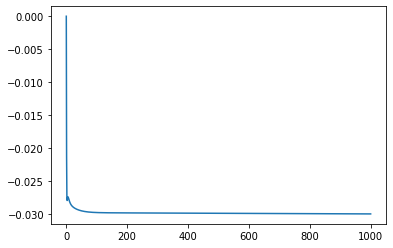

In [190]:
plt.plot(losses)

In [202]:
_, losses, gnorms, _ = sgd_dual(
    duality, dt, learning_rate=0.01, return_history=True, maxiter=1000, norm_factor=1, losstol=0, gradtol=0,
    arccos=False, x0=duality - theta
)

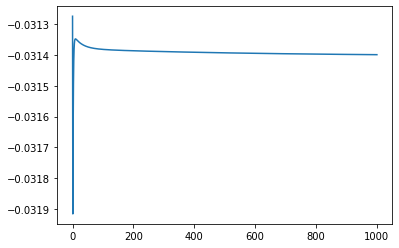

In [203]:
plt.plot(losses)

In [144]:
fidelity(duality, varqite)

0.999902755788969

In [14]:
xi0 = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=10_000, norm_factor=0, losstol=0, gradtol=0,
)

In [15]:
xi05 = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=10_000, norm_factor=0.5, losstol=0, gradtol=0,
)

In [16]:
xi1 = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=10_000, norm_factor=1, losstol=0, gradtol=0,
)

In [17]:
xi2 = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=10_000, norm_factor=2, losstol=0, gradtol=0,
)

In [54]:
xi10 = sgd_dual(
    theta, dt, learning_rate=0.01, return_history=True, maxiter=10_000, norm_factor=10, losstol=0, gradtol=0,
)

In [18]:
xi0_fids = [fidelity(th, varqite) for th in xi0[3]]

In [19]:
xi05_fids = [fidelity(th, varqite) for th in xi05[3]]

In [20]:
xi1_fids = [fidelity(th, varqite) for th in xi1[3]]

In [21]:
xi2_fids = [fidelity(th, varqite) for th in xi2[3]]

In [55]:
xi10_fids = [fidelity(th, varqite) for th in xi10[3]]

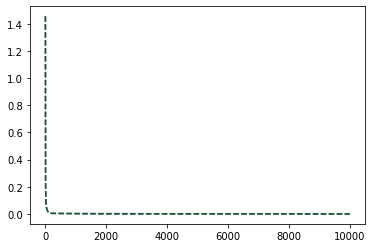

In [116]:
plt.plot(xi05[2], color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")
plt.plot(xi2[2], color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")



In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
ddd = (0, (3, 5, 1, 5, 1, 5))

axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[2].set_yscale("log")

axs[0].set_title("loss")
axs[1].set_title("gradient norm")
axs[2].set_title("fidelity")
axs[1].set_xlabel("\niterations")

axs[0].plot(xi0[1], color="k", alpha=1, label=r"$\xi = 0$")
axs[1].plot(xi0[2], color="k", alpha=1, label=r"$\xi = 0$")
axs[2].plot(xi0_fids, color="k", alpha=1, label=r"$\xi = 0$")

axs[0].plot(xi05[1], color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")
axs[1].plot(xi05[2], color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")
axs[2].plot(xi05_fids, color="#1C5334", alpha=1, ls="--", label=r"$\xi = 0.5$")

axs[0].plot(xi1[1], color="#58A279", alpha=1, ls="-.", label=r"$\xi = 1$")
axs[1].plot(xi1[2], color="#58A279", alpha=1, ls="-.", label=r"$\xi = 1$")
axs[2].plot(xi1_fids, color="#58A279", alpha=1, ls="-.", label=r"$\xi = 1$")

axs[0].plot(xi2[1], color="#ABD1BC", alpha=1, ls=ddd, label=r"$\xi = 2$")
axs[1].plot(xi2[2], color="#ABD1BC", alpha=1, ls=ddd, label=r"$\xi = 2$")
axs[2].plot(xi2_fids, color="#ABD1BC", alpha=1, ls=ddd, label=r"$\xi = 2$")

axs[0].plot(xi10[1], color="grey", alpha=1, ls=":", label=r"$\xi = 10$")
axs[1].plot(xi10[2], color="grey", alpha=1, ls=":", label=r"$\xi = 10$")
axs[2].plot(xi10_fids, color="grey", alpha=1, ls=":", label=r"$\xi = 10$")

axs[0].set_ylim(-0.032, -0.027)
axs[2].set_ylim(0.99996, 1)

plt.legend(bbox_to_anchor=(1, 0.7))
plt.tight_layout()

plt.savefig("norm_influence.pdf")
# axs[0][0].plot(xi2[1])
# axs[0][1].plot(xi2[2])
# axs[0][2].plot([fidelity(th, varqite) for th in xi1[2]])

In [745]:
fidelity(varqite, duality)

0.9999251933228616

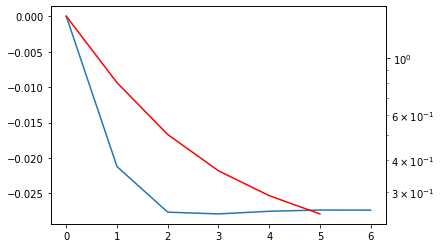

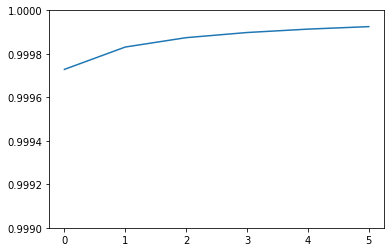

In [746]:
plt.plot(losses)
plt.twinx()
plt.yscale("log")
plt.plot(gnorms, color="red")
plt.figure()
plt.ylim(0.999, 1)
plt.plot([fidelity(varqite, th) for th in thetas])

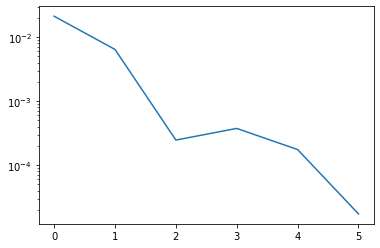

In [747]:
plt.semilogy(np.abs(np.diff(losses)))

In [650]:
duality1, losses1, gnorms1 = sgd_dual(theta, dt, learning_rate=0.01, store_loss=True, tol=1e-5, maxiter=10_000,
                                      norm_factor=1)

In [117]:
plt.plot(losses1)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.twinx()
plt.yscale("log")
plt.ylabel("gradient norm")
plt.plot(gnorms1, color="red")

NameError: name 'losses1' is not defined

In [668]:
fidelity(varqite, duality1)

0.9999985793366947

In [664]:
varqite - theta

array([ 0.00182837,  0.03554534,  0.00678196, -0.00116176,  0.0086149 ,
        0.0214572 ,  0.0203166 ,  0.00887997, -0.01739713, -0.01219593,
       -0.04354248, -0.0028332 , -0.00945801,  0.01210755, -0.00227047])

In [665]:
duality - theta

array([ 0.00497335,  0.00462456,  0.0955805 ,  0.05027523,  0.47718145,
        0.00811606, -0.0582446 , -0.1040468 , -0.19259406, -0.22136909,
       -0.05254062, -0.01144218, -0.09182109,  0.03244474, -0.36411504])

In [666]:
d_v, l_v, g_v = sgd_dual(theta, dt, learning_rate=0.01, store_loss=True, tol=1e-5, maxiter=100,
                         norm_factor=0, x0=varqite-theta)

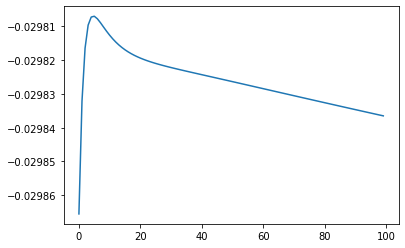

In [667]:
plt.plot(l_v)

## Full integration

In [146]:
def integrate(stepper, theta0, dt, T):
    thetas = [theta0]
    energies = [energy(theta0)]
    times = [0]
    
    while times[-1] < T:
        
        print(f"{times[-1]:.2f} / {T}", end="\r")
        next_theta = stepper(thetas[-1], dt)
            
        thetas.append(next_theta)
        energies.append(energy(next_theta))
        times.append(times[-1] + dt)
    
    return times, energies

In [147]:
theta0 = np.random.random(ansatz.num_parameters)
dt = 0.01
T = 1

times_mc, energies_mc = integrate(mclachlan, theta0, dt, T)

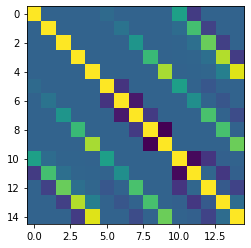

In [148]:
plt.imshow(ReverseQFI().compute(ansatz, theta0))

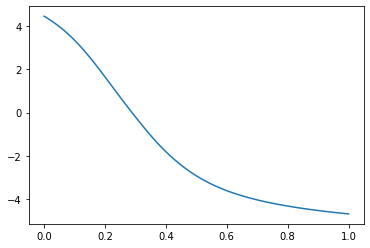

In [149]:
plt.plot(times_mc, energies_mc)

In [79]:
from functools import partial

In [549]:
# theta0 = np.zeros(ansatz.num_parameters)
dt = 0.01
T = 1

times, energies = integrate(partial(sgd_dual, tol=1e-3), theta0, dt, T)

In [77]:
plt.plot(times, energies, label="via fidelity")
plt.plot(times_mc, energies_mc, label="McLachlan")
plt.xlabel("time")
plt.ylabel("energy")
plt.legend(loc="best")

NameError: name 'times' is not defined

In [174]:
# theta0 = np.zeros(ansatz.num_parameters)
dt = 0.01
T = 1

times, energies = integrate(
    partial(sgd_dual, norm_factor=0, arccos=True, learning_rate=0.01, gradtol=1e-2, losstol=1e-4, maxiter=100), 
    theta0, 
    dt, 
    T
)

1.00 / 1
[-1.17756934e-16 -1.98714827e-16 -3.61857246e-17 -1.71582239e-16
  1.26688938e-16  7.85046229e-17 -4.41588504e-17  3.92523115e-17
 -1.26494695e-16  1.92998729e-16 -3.92523115e-17 -1.20210204e-16
  1.96261557e-16 -1.23653556e-16  5.86317071e-17]
0.9999722627613128
[ 3.58331307e-04 -3.97972210e-04 -3.91419650e-06  2.91468461e-03
 -1.65448256e-03 -3.14033904e-04 -5.76187359e-04  4.16591076e-05
  1.56472248e-03 -1.33415464e-03 -6.63496877e-04 -7.56039868e-04
  6.25857419e-04  2.60941238e-03 -2.15287489e-03]
0.9999257400517295
[ 6.70621289e-04 -6.15993364e-04  1.74563126e-05  4.69847048e-03
 -2.55367042e-03 -5.51585732e-04 -9.84210855e-04 -1.48722583e-05
  2.20849909e-03 -1.81221285e-03 -1.23295055e-03 -1.25254415e-03
  1.02500603e-03  4.20130829e-03 -3.39039798e-03]
0.9998803455808578
[ 9.47908033e-04 -7.21496053e-04  5.24821466e-05  5.82345958e-03
 -3.07300967e-03 -7.26501862e-04 -1.28601991e-03 -1.33206167e-04
  2.36954781e-03 -1.87783010e-03 -1.72123714e-03 -1.59412527e-03
  1.

0.9995220275191634
[ 0.00284314 -0.00031751  0.00020109  0.00884037 -0.00508361 -0.00115821
 -0.0022014  -0.00240002  0.00048375 -0.0004455  -0.00432799 -0.00285846
  0.00162883  0.00785973 -0.00628148]
-- Reached losstol.
1.03 / 1
[-0.00000000e+00 -4.29322157e-17 -4.23188983e-17 -9.68785309e-17
  3.60690416e-17 -1.57009246e-16  4.90653893e-18  1.17756934e-16
 -5.91331536e-17  8.50560115e-17 -3.92523115e-17  5.64251977e-17
  1.86448479e-16 -1.62498568e-16  9.72488482e-17]
0.9999671869243474
[ 0.00046553 -0.00039334 -0.00016306  0.00311057 -0.00189336 -0.00038053
 -0.0004311  -0.00022535  0.00165926 -0.0015117  -0.00071728 -0.00078614
  0.00048574  0.00276792 -0.00228384]
0.9999109750272888
[ 0.00086895 -0.00061152 -0.00025831  0.00504975 -0.0029655  -0.00066599
 -0.00073756 -0.0004759   0.0023376  -0.0020789  -0.00133574 -0.00130301
  0.00079028  0.00448412 -0.00361331]
0.999855027029568
[ 0.00122347 -0.00071948 -0.0003072   0.00629483 -0.0036132  -0.0008748
 -0.0009696  -0.00073705  0

0.9996953332739851
[ 0.00231466 -0.00078428 -0.00086874  0.00843745 -0.00511639 -0.00128841
 -0.00074428 -0.00229296  0.0022693  -0.00217879 -0.00297808 -0.00216235
  0.0007388   0.00724628 -0.0056131 ]
0.999638267457112
[ 0.00261911 -0.00076012 -0.00088501  0.0089144  -0.00542628 -0.00135957
 -0.00085492 -0.00262615  0.00196111 -0.00193091 -0.00336226 -0.00232265
  0.00078244  0.00763415 -0.00590756]
0.9995846060358661
[ 0.00288645 -0.00071754 -0.00087872  0.00926873 -0.00568128 -0.00140084
 -0.00096263 -0.00293279  0.00164336 -0.00168134 -0.00369908 -0.00245731
  0.0008181   0.00792372 -0.00613457]
0.9995340246094148
[ 0.00312111 -0.00066319 -0.00085617  0.00953834 -0.00589819 -0.0014203
 -0.00106724 -0.00321603  0.00133814 -0.00144642 -0.00399578 -0.00257471
  0.00084868  0.00814893 -0.00631558]
0.9994863486710774
[ 0.00332694 -0.00060151 -0.00082206  0.0097474  -0.00608665 -0.00142412
 -0.00116831 -0.00347819  0.00105566 -0.00123276 -0.00425836 -0.00268
  0.00087588  0.00833079 -0.

0.9994135698056742
[ 0.00390669 -0.00082905 -0.0015871   0.0106328  -0.00691427 -0.00154929
 -0.00026723 -0.00472339  0.00140574 -0.00175001 -0.00437935 -0.00256992
  0.00020864  0.00866862 -0.00654308]
0.9993550456846363
[ 0.00414891 -0.00078168 -0.00157572  0.01088391 -0.00715011 -0.00154721
 -0.00036572 -0.00503237  0.00110157 -0.00152466 -0.0046675  -0.00267297
  0.00022426  0.00887353 -0.00669945]
0.9993006788576746
[ 0.00435879 -0.00072805 -0.00155167  0.01108017 -0.00735553 -0.00153447
 -0.00046455 -0.00531287  0.00082677 -0.00132343 -0.00492233 -0.00276776
  0.00024023  0.00904401 -0.00682823]
-- Reached losstol.
0.9999999999999998
[-0.00000000e+00 -1.15303665e-16 -7.35980840e-18 -2.74107528e-17
 -6.71081586e-17  7.85046229e-17  8.09578924e-17 -2.20794252e-16
  6.84197752e-17 -6.50910648e-17  1.96261557e-17 -1.18983569e-16
 -9.81307787e-17  4.54308879e-17  4.13255714e-17]
0.9999500891734768
[ 8.42932245e-04 -4.18724705e-04 -6.12544840e-04  3.62538520e-03
 -2.43099489e-03 -5.345

0.9994802392366509
[ 0.00395959 -0.00126459 -0.0022922   0.01063607 -0.00696376 -0.00160001
  0.00121212 -0.0055927   0.00266016 -0.00297845 -0.00365193 -0.0021009
 -0.00071641  0.00804184 -0.00583475]
0.9993816387244921
[ 0.00443403 -0.0013163  -0.00243343  0.01135128 -0.00747484 -0.00165729
  0.0011885  -0.00617704  0.0023208  -0.00273427 -0.00413314 -0.00224195
 -0.00076174  0.00853285 -0.0061763 ]
0.9992917877356559
[ 0.00483787 -0.00134085 -0.00252527  0.01189095 -0.00789323 -0.00167977
  0.00113158 -0.00667528  0.00196735 -0.00247659 -0.00455225 -0.00235952
 -0.00079122  0.00890467 -0.00643986]
0.9992100670712971
[ 0.00518157 -0.00134538 -0.00258063  0.01230304 -0.00824307 -0.00167907
  0.00105345 -0.00710591  0.00162723 -0.00222874 -0.00491782 -0.00246251
 -0.00080947  0.00919559 -0.00664855]
-- Reached losstol.
1.04 / 1
[-1.17756934e-16 -1.17756934e-16 -1.57009246e-16 -2.88195776e-16
 -1.85064792e-16 -7.85046229e-17  4.95253774e-17  5.88784672e-17
 -7.68522459e-17 -1.82165497e-

0.9984064846732693
[ 0.00810288 -0.00175311 -0.00319852  0.01495616 -0.01114677 -0.00138806
  0.00103434 -0.01198859 -0.00010256 -0.00124487 -0.00761855 -0.0032705
 -0.00176213  0.01108526 -0.00757375]
0.9983881309393666
[ 0.0081305  -0.00171574 -0.00318602  0.01494367 -0.01119168 -0.0013803
  0.00098153 -0.01207029 -0.00014523 -0.00121659 -0.00767859 -0.00332061
 -0.0017588   0.0111356  -0.00759159]
0.9983714336653259
[ 0.00815375 -0.00167916 -0.00317461  0.0149287  -0.01123143 -0.00137416
  0.00093246 -0.0121442  -0.00018264 -0.00119191 -0.00773265 -0.0033683
 -0.00175529  0.01118212 -0.0076074 ]
0.9983562120608898
[ 0.00817335 -0.00164356 -0.0031643   0.01491199 -0.01126669 -0.00136942
  0.00088689 -0.01221116 -0.00021552 -0.00117028 -0.00778143 -0.00341362
 -0.00175167  0.01122518 -0.00762149]
0.9983423085368243
[ 0.00818988 -0.00160907 -0.00315506  0.0148941  -0.01129804 -0.00136585
  0.00084458 -0.01227192 -0.00024452 -0.00115125 -0.00782551 -0.00345662
 -0.00174799  0.01126509 -

0.9983076220068541
[ 0.00890914 -0.00251053 -0.00371717  0.01569164 -0.01149474 -0.00148486
  0.00213928 -0.01332033  0.00037583 -0.00189204 -0.00778602 -0.00299258
 -0.00247773  0.01094302 -0.00733794]
0.9982862307506524
[ 0.00894476 -0.00247811 -0.00371406  0.01568438 -0.01154935 -0.00147545
  0.00207807 -0.01341505  0.00032614 -0.00185813 -0.00785852 -0.0030483
 -0.00247894  0.01100353 -0.00736193]
0.9982669470091216
[ 0.0089743  -0.00244521 -0.00371101  0.01567257 -0.01159719 -0.00146836
  0.00202101 -0.01349989  0.00028297 -0.00182878 -0.00792345 -0.00310161
 -0.00247954  0.01105924 -0.00738296]
0.9982495094086858
[ 0.00899884 -0.00241223 -0.00370817  0.01565742 -0.01163923 -0.00146326
  0.00196786 -0.01357605  0.00024537 -0.00180329 -0.00798174 -0.00315251
 -0.00247966  0.01111063 -0.00740151]
0.9982336944044242
[ 0.00901924 -0.00237951 -0.00370566  0.01563989 -0.01167629 -0.00145985
  0.00191836 -0.01364456  0.00021249 -0.00178105 -0.00803421 -0.003201
 -0.00247943  0.01115813 -

0.99814417841417
[ 0.00950958 -0.00270184 -0.00394394  0.01586605 -0.01184301 -0.00155837
  0.00243141 -0.01452382  0.00040042 -0.00216471 -0.00827583 -0.00317331
 -0.0028691   0.0111098  -0.00726332]
0.998132578850619
[ 0.0095202  -0.00267303 -0.00394706  0.01584471 -0.01186752 -0.00156015
  0.002391   -0.01457156  0.00037976 -0.00215047 -0.00831439 -0.00321521
 -0.00287026  0.01114783 -0.00727537]
0.998121945232687
[ 0.00952904 -0.00264502 -0.00395017  0.01582326 -0.01188937 -0.00156266
  0.00235331 -0.01461475  0.00036144 -0.00213786 -0.0083495  -0.00325489
 -0.00287129  0.01118315 -0.00728628]
0.9981121735862168
[ 0.00953643 -0.00261791 -0.00395326  0.01580196 -0.0119089  -0.00156575
  0.00231816 -0.0146539   0.00034514 -0.00212662 -0.00838155 -0.00329242
 -0.00287222  0.01121599 -0.00729621]
0.9981031742550034
[ 0.00954263 -0.00259178 -0.00395635  0.01578105 -0.01192641 -0.00156928
  0.00228537 -0.01468945  0.00033058 -0.00211659 -0.00841086 -0.00332788
 -0.00287308  0.01124653 -0

0.9980193898188615
[ 0.01028218 -0.00357614 -0.00428335  0.01618559 -0.01192036 -0.00168707
  0.00337251 -0.01586979  0.00093519 -0.00287268 -0.00861547 -0.00314442
 -0.00358393  0.01100401 -0.00702503]
-- Reached losstol.
1.02 / 1
[-0.00000000e+00  3.43457725e-17 -0.00000000e+00  6.58546125e-17
  3.27502994e-18 -0.00000000e+00  9.81307787e-18  1.47196168e-16
  7.04879641e-17 -8.78101238e-17  7.85046229e-17 -1.34929821e-17
  1.37383090e-16  4.95943373e-17 -7.27079256e-17]
0.9999079078832599
[ 0.00200968 -0.00098683 -0.00070972  0.00404421 -0.00283227 -0.00104126
  0.00197617 -0.0033442   0.00196607 -0.00238565 -0.00129767 -0.00068537
 -0.00083681  0.00253029 -0.00186381]
0.9997212907009554
[ 0.00365673 -0.00174365 -0.00131325  0.00706859 -0.00480247 -0.00167644
  0.0032793  -0.00590742  0.00293918 -0.00365681 -0.00240274 -0.00110239
 -0.00150391  0.00436048 -0.00307785]
0.9995127843460916
[ 0.00500077 -0.00233239 -0.00182106  0.00934652 -0.00622925 -0.00204178
  0.00412089 -0.00788962 

0.9985795652260842
[ 0.00948416 -0.00447352 -0.00330521  0.01514234 -0.00988083 -0.00231982
  0.00575816 -0.01406305  0.00274049 -0.00464913 -0.00668396 -0.00183051
 -0.00379046  0.00877335 -0.00571111]
0.9984933237800663
[ 0.00978768 -0.00460578 -0.0034558   0.01549253 -0.01014779 -0.00225485
  0.00572014 -0.01449516  0.00258465 -0.00455807 -0.00696668 -0.00188835
 -0.00389585  0.00899606 -0.00584599]
0.9984203185949049
[ 0.01003002 -0.00470865 -0.00358325  0.01575852 -0.01036659 -0.00219332
  0.00566565 -0.01485238  0.00244694 -0.00447313 -0.00720781 -0.00194751
 -0.00397792  0.0091816  -0.00595738]
0.9983584388978525
[ 0.01022326 -0.00478726 -0.00369148  0.01595893 -0.01054675 -0.00213763
  0.00560186 -0.01514981  0.00232741 -0.0043964  -0.00741443 -0.00200793
 -0.00404181  0.00933862 -0.00604995]
0.998305859475942
[ 0.01037715 -0.00484584 -0.00378377  0.01610821 -0.01069576 -0.00208884
  0.00553353 -0.01539917  0.00222485 -0.00432841 -0.0075923  -0.00206918
 -0.00409156  0.00947341

0.998024722049094
[ 0.01119023 -0.00546657 -0.00420826  0.01625485 -0.01103489 -0.00204863
  0.00548103 -0.01700996  0.00211981 -0.00450099 -0.00864693 -0.00264669
 -0.00459333  0.00999403 -0.00626607]
-- Reached losstol.
1.05 / 1
[-1.57009246e-16  5.88784672e-17  1.03037318e-16  2.74676504e-16
 -3.85143526e-17  3.92523115e-17 -1.47196168e-17 -2.29380695e-16
  1.20333246e-17 -1.19303495e-17 -0.00000000e+00 -9.44508745e-17
  5.88784672e-17  8.26740173e-17  2.98018143e-17]
0.9999024256161593
[ 0.00231598 -0.00129339 -0.00035507  0.00376246 -0.0026674  -0.00128929
  0.00245974 -0.00369697  0.00190542 -0.00250752 -0.00149996 -0.00065295
 -0.00097362  0.00222299 -0.00168254]
0.9997032948897226
[ 0.00418133 -0.0023013  -0.00073189  0.0066468  -0.00452726 -0.00205775
  0.00409065 -0.00652576  0.00292366 -0.0039555  -0.00272271 -0.00104843
 -0.00177748  0.00387865 -0.00278126]
0.9994805790852909
[ 0.00567754 -0.00309667 -0.0011052   0.00886284 -0.00586976 -0.00248878
  0.00515925 -0.00870505  

0.9982510936259549
[ 0.01118845 -0.00657027 -0.00320586  0.01553931 -0.00970645 -0.00247965
  0.00711196 -0.01648996  0.0031694  -0.00575883 -0.00793725 -0.00208048
 -0.00500381  0.00871317 -0.00551659]
0.9982175555442545
[ 0.011273   -0.00662438 -0.00330612  0.01562765 -0.0097828  -0.00244037
  0.00706732 -0.01665352  0.00312784 -0.00573344 -0.0080529  -0.00213362
 -0.00503722  0.00880005 -0.00555998]
0.9981891919709126
[ 0.0113383  -0.00666423 -0.00339421  0.01569179 -0.00984565 -0.00240797
  0.00702207 -0.01679112  0.00309297 -0.00571054 -0.00815323 -0.00218588
 -0.00506233  0.00887633 -0.00559658]
0.9981650622585949
[ 0.01138853 -0.00669244 -0.0034717   0.01573706 -0.00989767 -0.00238176
  0.00697719 -0.01690761  0.00306376 -0.00569003 -0.00824079 -0.002237
 -0.00508122  0.00894397 -0.00562763]
0.9981444000820962
[ 0.01142699 -0.00671121 -0.00353998  0.01576768 -0.00994099 -0.00236102
  0.00693327 -0.01700687  0.00303929 -0.00567174 -0.00831765 -0.00228676
 -0.00509547  0.00900448 

0.9999999999999991
[ 7.85046229e-17  2.94392336e-17 -6.37850061e-17 -9.33515722e-18
 -6.06154623e-17  7.85046229e-17  4.90653893e-17  6.37850061e-17
  8.82894453e-17 -1.23767471e-16  7.85046229e-17 -1.96261557e-17
 -5.88784672e-17 -4.91229825e-17 -9.24623717e-17]
0.99990189156391
[ 0.00252895 -0.00167379  0.0001475   0.00322751 -0.00230961 -0.00154807
  0.00284059 -0.00385336  0.00194474 -0.00264762 -0.00171256 -0.00069925
 -0.00114425  0.00192104 -0.0015058 ]
0.9997021081742807
[ 0.00452097 -0.00298759  0.0001119   0.0057518  -0.00390849 -0.0024627
  0.00473699 -0.00679245  0.00308342 -0.00429834 -0.00304831 -0.00115116
 -0.00210148  0.00337644 -0.00249103]
0.9994800941834805
[ 6.08608979e-03 -4.02821709e-03 -3.89848046e-05  7.72388985e-03
 -5.04632086e-03 -2.97368662e-03  5.99807403e-03 -9.04633980e-03
  3.73093502e-03 -5.32810623e-03 -4.09482233e-03 -1.44956466e-03
 -2.88722513e-03  4.47242030e-03 -3.15735768e-03]
0.9992693585840451
[ 0.00731343 -0.00485817 -0.00025672  0.00926374 -

0.9982590826659593
[ 0.01142162 -0.00842067 -0.00242785  0.0139455  -0.00792402 -0.0028695
  0.00846518 -0.01700898  0.00443547 -0.00734234 -0.00825912 -0.00279406
 -0.0058346   0.00774934 -0.00483708]
0.9982473531929731
[ 0.01143772 -0.00843629 -0.00249135  0.01396718 -0.00794076 -0.00285107
  0.00844601 -0.01707387  0.00442987 -0.00733955 -0.00830245 -0.00282802
 -0.00583585  0.00778407 -0.00484912]
0.9982373166327205
[ 0.01144923 -0.00844644 -0.0025472   0.01398196 -0.00795476 -0.00283617
  0.00842686 -0.01712989  0.0044252  -0.00733654 -0.0083406  -0.00286003
 -0.00583533  0.00781576 -0.00485965]
0.998228670069916
[ 0.01145727 -0.00845226 -0.00259636  0.01399132 -0.00796658 -0.00282433
  0.00840791 -0.01717854  0.00442127 -0.00733343 -0.0083744  -0.00289023
 -0.00583368  0.00784483 -0.00486894]
-- Reached losstol.
0.9999999999999987
[ 1.57009246e-16 -8.83177008e-17 -4.90653893e-18 -2.09157597e-16
 -2.23214759e-17  7.85046229e-17 -8.46377966e-17  1.37383090e-16
 -1.16913783e-16  8.6

0.9984796125044557
[ 0.01079842 -0.00862132 -0.00113417  0.01225487 -0.00658153 -0.00343785
  0.00902064 -0.01590604  0.00505121 -0.0079457  -0.00771689 -0.00296566
 -0.00596407  0.00679734 -0.00433791]
0.9984546539491821
[ 0.01086435 -0.00869518 -0.00125614  0.01235103 -0.00661425 -0.00339382
  0.00902147 -0.01604677  0.00504613 -0.00795958 -0.00779243 -0.00301212
 -0.00599158  0.00685077 -0.00435847]
0.9984339703140156
[ 0.01091437 -0.00875247 -0.00136393  0.01242583 -0.00664034 -0.0033556
  0.00901818 -0.01616441  0.0050415  -0.00796947 -0.00785619 -0.00305405
 -0.00600935  0.00689701 -0.00437546]
0.998416760408758
[ 0.01095211 -0.00879648 -0.00145889  0.01248364 -0.0066613  -0.00332272
  0.0090121  -0.01626348  0.00503743 -0.00797642 -0.00791035 -0.00309204
 -0.00601985  0.00693763 -0.00438967]
0.9984023779152938
[ 0.01098037 -0.00882984 -0.0015424   0.0125279  -0.00667829 -0.00329462
  0.00900416 -0.0163475   0.00503395 -0.00798121 -0.00795664 -0.00312659
 -0.00602503  0.00697377 

0.9987747469881905
[ 0.00963132 -0.00813059  0.00027741  0.01005219 -0.00528918 -0.0040777
  0.00914886 -0.01418226  0.00545006 -0.00810952 -0.00693938 -0.00306993
 -0.00573014  0.00580305 -0.0038645 ]
0.9987265460857868
[ 0.00980757 -0.00832045  0.00010119  0.0102863  -0.00535145 -0.00402
  0.00921008 -0.01447238  0.00546459 -0.0081785  -0.00707779 -0.00315678
 -0.00583887  0.00590329 -0.0039051 ]
0.9986871017402028
[ 9.94388358e-03 -8.47084085e-03 -6.07161666e-05  1.04721983e-02
 -5.39900291e-03 -3.96466954e-03  9.25085652e-03 -1.47073738e-02
  5.47236219e-03 -8.22928561e-03 -7.19002184e-03 -3.23136613e-03
 -5.91877223e-03  5.98398793e-03 -3.93648528e-03]
0.9986547565305459
[ 0.01004925 -0.00858956 -0.00020752  0.01061961 -0.0054356  -0.00391354
  0.0092775  -0.01489932  0.00547613 -0.00826703 -0.00728169 -0.00329576
 -0.0059764   0.0060502  -0.00396111]
0.9986281620443673
[ 0.01013061 -0.00868288 -0.00033934  0.01073627 -0.00546401 -0.00386738
  0.00929433 -0.01505741  0.0054776  -0

0.9993155124837191
[ 0.00695165 -0.00596201  0.00167645  0.00640318 -0.00376242 -0.00444141
  0.00804225 -0.01038106  0.00514659 -0.0070582  -0.00519216 -0.00250576
 -0.00430864  0.00414409 -0.00310223]
0.9992027340713789
[ 0.00752609 -0.00653536  0.00157206  0.0070454  -0.00397556 -0.00453905
  0.00848098 -0.01124757  0.00536937 -0.00745214 -0.00559842 -0.00275056
 -0.00472481  0.00447625 -0.00326789]
0.9991094637457713
[ 0.00796871 -0.00699284  0.00142815  0.00756029 -0.00412716 -0.00456688
  0.00878219 -0.01192116  0.00551146 -0.00772963 -0.0059108  -0.00295249
 -0.00504883  0.00472763 -0.00338479]
0.9990329856910245
[ 0.00831092 -0.0073576   0.00126503  0.00797271 -0.0042362  -0.0045545
  0.00898978 -0.01244864  0.00560185 -0.00792745 -0.00615323 -0.00312032
 -0.00529911  0.00491928 -0.0034686 ]
0.998970521722985
[ 0.00857631 -0.00764804  0.00109617  0.00830281 -0.00431545 -0.00452043
  0.00913334 -0.01286492  0.00565917 -0.00807022 -0.00634306 -0.00326066
 -0.00549087  0.00506693 

1.08 / 1
[ 4.71027738e-16  8.71576399e-33  2.02394731e-17  1.27107136e-16
  4.28590565e-17 -1.57009246e-16  1.27570012e-16 -0.00000000e+00
  7.17408895e-18 -4.32325307e-17 -3.92523115e-16  1.07943857e-16
  2.55140025e-16  4.97338229e-17  2.25837214e-17]
0.999932354398943
[ 0.00200922 -0.00166724  0.00096336  0.00149428 -0.00122838 -0.00201715
  0.00300855 -0.00308284  0.00206978 -0.00259421 -0.00160401 -0.00079588
 -0.00119216  0.00116231 -0.00112921]
0.9997982166635984
[ 0.00351441 -0.00299291  0.00154735  0.00273605 -0.0020332  -0.00326933
  0.00504269 -0.0054057   0.00340798 -0.00434004 -0.00277604 -0.00142222
 -0.00217516  0.00206204 -0.00186558]
0.9996535564195382
[ 0.00464851 -0.0040497   0.00186664  0.00375766 -0.00256652 -0.00402952
  0.00642235 -0.00716428  0.00427384 -0.00552518 -0.0036391  -0.00192219
 -0.00297353  0.00275041 -0.0023517 ]
0.9995201943615609
[ 0.00550822 -0.00489352  0.00200543  0.00459208 -0.00292392 -0.00447588
  0.00736159 -0.00850268  0.00483452 -0.006337

0.9989903069720169
[ 0.00783751 -0.00774703  0.00084217  0.00719782 -0.00339749 -0.00477554
  0.00943034 -0.0125441   0.00586676 -0.00818609 -0.00599862 -0.00430388
 -0.00569747  0.0048013  -0.00332827]
0.9989843277775241
[ 0.00785914 -0.00776451  0.0007898   0.00721769 -0.0033995  -0.00475967
  0.00943497 -0.01258806  0.00586728 -0.00819401 -0.00601116 -0.00433002
 -0.00570235  0.00482633 -0.00333289]
0.9989792648368779
[ 0.00787734 -0.00777753  0.00074333  0.00723258 -0.00340119 -0.00474585
  0.00943838 -0.01262612  0.00586758 -0.00820028 -0.00602098 -0.00435244
 -0.0057045   0.00484937 -0.003337  ]
-- Reached losstol.
1.00 / 1
[-0.00000000e+00 -1.96261557e-17  2.67559701e-17 -9.12045440e-17
  2.81483448e-17 -1.96261557e-17  7.11448145e-17 -9.81307787e-17
  5.65220152e-17 -2.47711018e-17 -1.57009246e-16  8.58644313e-17
 -5.39719283e-17 -2.85657463e-17  1.99148982e-17]
0.9999412404730813
[ 0.00172986 -0.00150136  0.00100311  0.00117    -0.00106373 -0.0020961
  0.00297886 -0.00279691  

0.9991565568993133
[ 0.00664791 -0.00695946  0.00135205  0.00581366 -0.00286785 -0.00515688
  0.00931229 -0.01119168  0.00577165 -0.00777716 -0.00522977 -0.00446811
 -0.00540207  0.00432658 -0.00311268]
0.999150626650462
[ 0.00667403 -0.00698227  0.0012996   0.00583555 -0.00286889 -0.00514115
  0.00931973 -0.01123493  0.00577261 -0.0077869  -0.00524273 -0.00449978
 -0.00541559  0.00435346 -0.00311723]
0.9991456162544161
[ 0.00669632 -0.00699976  0.00125281  0.00585218 -0.00286975 -0.00512742
  0.0093255  -0.01127198  0.00577321 -0.00779463 -0.00525268 -0.0045268
 -0.00542523  0.00437796 -0.00312119]
-- Reached losstol.
1.02 / 1
[-1.57009246e-16 -1.96261557e-17  1.53329342e-17  8.16337427e-18
 -2.66798902e-17 -1.57009246e-16  1.15303665e-16 -1.57009246e-16
 -1.45491449e-16  1.08270712e-16 -0.00000000e+00  1.00584048e-16
  2.33060599e-17  1.71166320e-16  2.82189226e-17]
0.9999493826070542
[ 0.00142542 -0.00131634  0.0010094   0.00089168 -0.00093683 -0.00216764
  0.00294506 -0.00250884  0

1.04 / 1
[-3.14018492e-16  1.96261557e-17  6.01051019e-17 -1.29518567e-16
  4.09633750e-17 -1.57009246e-16  9.69041439e-17 -3.92523115e-17
  5.34415308e-17 -3.69685224e-17  3.14018492e-16 -9.56775092e-17
  2.94392336e-17  4.52974099e-17 -2.47928048e-17]
0.9999564043705017
[ 0.00111419 -0.00113073  0.00099274  0.00065964 -0.0008428  -0.00222921
  0.00290934 -0.00223294  0.00188421 -0.00217466 -0.00096705 -0.00092548
 -0.00092229  0.00080184 -0.00093278]
0.9998720673606037
[ 0.00196186 -0.00203888  0.00164923  0.00125067 -0.00138602 -0.0036416
  0.00486024 -0.00390943  0.00311473 -0.00364399 -0.0016971  -0.0016397
 -0.00168967  0.00143822 -0.00154949]
0.9997833973739676
[ 0.00260896 -0.00277143  0.00206539  0.00176442 -0.00173623 -0.00452542
  0.00617374 -0.00517373  0.00391936 -0.00464429 -0.00224963 -0.00220218
 -0.00232182  0.00193807 -0.00195967]
0.9997034946725726
[ 0.00310555 -0.0033641   0.00231216  0.00220178 -0.0019619  -0.00506889
  0.00706239 -0.00613161  0.00444623 -0.0053310

0.9996907565996406
[ 0.00264061 -0.00327977  0.00244305  0.00192473 -0.00193532 -0.00554108
  0.0075214  -0.00606448  0.00453738 -0.0053533  -0.00236763 -0.0031325
 -0.00297107  0.00241451 -0.00229717]
0.9996445134504034
[ 0.00288158 -0.00362022  0.00251423  0.00216547 -0.00201936 -0.00574185
  0.00792064 -0.00655459  0.0047532  -0.00565829 -0.00258158 -0.00343158
 -0.00328991  0.00263886 -0.00241744]
0.9996070752868228
[ 0.00307265 -0.00389886  0.00253298  0.00236485 -0.0020723  -0.00585387
  0.00819511 -0.00693068  0.0048953  -0.00587351 -0.00274969 -0.00367772
 -0.00355059  0.00281649 -0.00249989]
0.9995768517558153
[ 0.00322522 -0.00412698  0.00251739  0.00252862 -0.00210526 -0.00591077
  0.00838555 -0.00722083  0.00498898 -0.00602706 -0.00288228 -0.00388182
 -0.00376368  0.00295813 -0.00255699]
0.999552420576028
[ 0.003348   -0.00431372  0.00248027  0.00266223 -0.00212544 -0.00593413
  0.00851907 -0.00744595  0.00505083 -0.00613789 -0.00298724 -0.00405198
 -0.00393794  0.00307211 

1.04 / 1
[ 1.57009246e-16  6.37850061e-17  1.59462515e-17  7.14537534e-17
  6.47210942e-18  3.92523115e-17 -7.35980840e-17  7.85046229e-17
 -2.98344350e-18 -3.12170007e-17 -0.00000000e+00  5.39719283e-17
  1.96261557e-17  5.96401989e-17 -6.25040217e-18]
0.9999730919791604
[ 4.69350463e-05 -6.30582522e-04  8.06665679e-04  1.36188425e-04
 -6.54133312e-04 -2.28422029e-03  2.73549800e-03 -1.43706370e-03
  1.42303872e-03 -1.52001484e-03 -1.16775513e-04 -1.23516320e-03
 -6.50729554e-04  6.09292345e-04 -7.44798964e-04]
0.9999229098602487
[ 0.00016584 -0.00114782  0.00136224  0.00029484 -0.00108112 -0.00373191
  0.00453621 -0.00251221  0.00235594 -0.00254146 -0.00029579 -0.00212287
 -0.00119642  0.0010975  -0.00124307]
0.9998720972327327
[ 0.00030656 -0.00157578  0.00173557  0.00045398 -0.00135877 -0.0046426
  0.00572621 -0.00331953  0.00296806 -0.00323181 -0.00048741 -0.00277734
 -0.0016525   0.00148685 -0.00157705]
-- Reached losstol.
0.9999999999999993
[ 2.35513869e-16 -1.47196168e-17  1.10

0.9999999999999996
[-2.35513869e-16  3.92523115e-17 -2.08527905e-17 -1.46047960e-16
  1.10270451e-16  1.57009246e-16 -9.26109224e-17  1.96261557e-16
 -2.51695827e-20 -4.53938568e-17  1.57009246e-16 -1.42289629e-16
 -1.96261557e-17  1.71337052e-17  1.29013214e-16]
0.9999788023134902
[-4.91824916e-04 -4.51192648e-04  6.65621290e-04 -2.62931106e-05
 -5.77128275e-04 -2.21714580e-03  2.57937012e-03 -1.06860602e-03
  1.09465060e-03 -1.11981020e-03  3.08381700e-04 -1.37982150e-03
 -5.01460336e-04  5.47101855e-04 -6.36285011e-04]
0.9999402666876946
[-7.44146393e-04 -8.30642878e-04  1.12826319e-03 -1.07743392e-05
 -9.56440469e-04 -3.61588566e-03  4.25956697e-03 -1.86593109e-03
  1.81340237e-03 -1.86799897e-03  4.13170172e-04 -2.35273649e-03
 -9.22573014e-04  9.83816653e-04 -1.06127860e-03]
0.9999022894328553
[-8.62228507e-04 -1.15241178e-03  1.44319070e-03  2.52292614e-05
 -1.20496963e-03 -4.49295116e-03  5.35753899e-03 -2.46272040e-03
  2.28564286e-03 -2.36998144e-03  4.12622170e-04 -3.0534041

0.999806602259277
[-1.57672437e-03 -2.14031773e-03  1.73843759e-03 -2.77092046e-05
 -1.55794089e-03 -5.68083056e-03  7.04157835e-03 -3.38087190e-03
  2.70792588e-03 -2.79936889e-03  5.77473142e-04 -4.91215850e-03
 -2.24109533e-03  2.32129641e-03 -1.73612063e-03]
-- Reached losstol.
1.07 / 1
[-0.00000000e+00  1.47196168e-17 -4.17055809e-17 -8.51852162e-17
 -9.31518679e-17  4.90653893e-17 -4.69187786e-17 -3.92523115e-17
 -2.83529943e-17  8.29526295e-17 -0.00000000e+00 -9.81307787e-18
  3.92523115e-17  1.82869121e-17 -8.78273234e-17]
0.9999814278590422
[-7.77109874e-04 -3.59143494e-04  5.81583772e-04 -9.06125405e-05
 -5.36546510e-04 -2.15767754e-03  2.46050717e-03 -8.48888534e-04
  8.98991849e-04 -8.92906948e-04  5.38747532e-04 -1.40515396e-03
 -4.05214098e-04  5.08217357e-04 -5.76486346e-04]
0.9999482393895986
[-0.00123174 -0.00066749  0.00098837 -0.00013443 -0.00088997 -0.00351529
  0.00405278 -0.00148023  0.00148973 -0.00148659  0.00080451 -0.00239044
 -0.00074307  0.00091296 -0.000960

0.999847682347556
[-0.00232224 -0.0016102   0.0015791  -0.00027018 -0.00144947 -0.00547121
  0.00651455 -0.00252783  0.00220443 -0.00218288  0.00126226 -0.00456923
 -0.00161637  0.00199404 -0.00155288]
0.9998410629734796
[-0.00233571 -0.00171571  0.00158427 -0.00027028 -0.00146696 -0.00550761
  0.00659114 -0.00259719  0.00223222 -0.00221337  0.00123623 -0.00469167
 -0.00171255  0.00207896 -0.00157357]
-- Reached losstol.
1.01 / 1
[ 3.14018492e-16  3.67990420e-17 -6.13317367e-18 -8.14106273e-17
  8.08217089e-18  7.85046229e-17 -6.48966439e-17  1.17756934e-16
  2.00821897e-17  1.46113156e-17 -3.14018492e-16  1.66822324e-16
 -5.88784672e-17 -4.86919516e-18  3.80104393e-18]
0.9999832437470508
[-0.00097802 -0.0002981   0.00051266 -0.00012236 -0.00050666 -0.00209331
  0.00234759 -0.00067413  0.00074575 -0.00072179  0.00070795 -0.00138589
 -0.00032642  0.00047127 -0.0005323 ]
0.9999536872090731
[-0.00157886 -0.0005583   0.00087334 -0.00019778 -0.00084065 -0.00340776
  0.0038588  -0.00117365  

0.9998604780640414
[-0.00290044 -0.00154451  0.00141149 -0.00039318 -0.00138964 -0.00528477
  0.00621157 -0.00205128  0.00184646 -0.00176252  0.00171535 -0.00454573
 -0.0013226   0.00192127 -0.00144398]
-- Reached losstol.
1.05 / 1
[-0.00000000e+00  4.29322157e-17  2.33060599e-17  2.69261450e-16
 -3.22548013e-17 -9.81307787e-18  6.43168673e-17 -7.85046229e-17
  1.71495874e-17 -5.55485967e-17 -1.57009246e-16 -9.81307787e-18
 -2.15887713e-16  8.54548979e-17 -1.01298776e-16]
0.9999847219039937
[-0.00111978 -0.00027236  0.00044855 -0.00013388 -0.00047817 -0.00201004
  0.00223111 -0.00053508  0.000616   -0.00058218  0.00082916 -0.0013474
 -0.00025092  0.00043533 -0.00049256]
0.9999579843802598
[-0.001828   -0.0005108   0.00076547 -0.00022378 -0.00079345 -0.00326906
  0.00366136 -0.00093082  0.00102114 -0.00096533  0.00130929 -0.00228989
 -0.00045311  0.00078121 -0.00081756]
0.999932816347407
[-0.00227722 -0.00071903  0.00098634 -0.0002847  -0.00100128 -0.00405381
  0.00457921 -0.00122422  0

0.9999204258018349
[-0.00283828 -0.00088429  0.0009914  -0.00034416 -0.00107217 -0.00430999
  0.00487893 -0.00113992  0.00120793 -0.00110934  0.00196326 -0.00331585
 -0.00052912  0.00117396 -0.00108305]
0.9999064953930602
[-0.00305576 -0.00103511  0.00108064 -0.00038003 -0.00115763 -0.00458978
  0.00523217 -0.0012688   0.00130328 -0.0011946   0.00206496 -0.00365434
 -0.00061398  0.00133666 -0.0011683 ]
0.9998961225488301
[-0.00319933 -0.00116543  0.00113834 -0.00040693 -0.00121421 -0.00475839
  0.00545821 -0.001365    0.00136607 -0.00124991  0.00211746 -0.00390397
 -0.00068944  0.00146784 -0.00122435]
0.9998884013294865
[-0.00329477 -0.00127834  0.00117348 -0.00042744 -0.00125173 -0.0048581
  0.00560286 -0.00143683  0.00140747 -0.00128567  0.00214129 -0.00409014
 -0.00075756  0.00157408 -0.0012612 ]
0.9998825935833325
[-0.0033587  -0.0013765   0.00119263 -0.00044337 -0.00127668 -0.00491548
  0.00569542 -0.00149042  0.00143477 -0.00130865  0.00214892 -0.00423042
 -0.00081972  0.00166051

1.04 / 1
[ 3.14018492e-16  7.72779882e-17  3.28124791e-17 -1.82480459e-16
  1.25588521e-16 -5.88784672e-17  1.25730060e-17 -1.17756934e-16
  1.86264538e-17  1.11105590e-17 -0.00000000e+00  1.47196168e-16
 -7.85046229e-17 -1.25768565e-16  7.08274089e-17]
0.9999874580709753
[-1.28361671e-03 -2.89963733e-04  3.21174329e-04 -1.25764869e-04
 -4.16180411e-04 -1.78486162e-03  1.96707749e-03 -3.04098620e-04
  4.00433393e-04 -3.60312231e-04  9.75946160e-04 -1.22355451e-03
 -8.71040056e-05  3.56363799e-04 -4.15051266e-04]
0.9999656006098577
[-0.0021283  -0.00053468  0.00055041 -0.00021778 -0.00069055 -0.00289498
  0.00322025 -0.00053161  0.00066384 -0.00059414  0.00157632 -0.00208433
 -0.0001542   0.00063982 -0.00068697]
0.9999451618193728
[-0.00268758 -0.00074086  0.00071205 -0.000286   -0.00087167 -0.00358121
  0.00401856 -0.0007023   0.00083713 -0.00074532  0.0019421  -0.00269761
 -0.00021017  0.00086599 -0.0008651 ]
0.9999287844812378
[-0.00306032 -0.00091467  0.00082411 -0.00033728 -0.00099

0.999923238085385
[-3.43080809e-03 -1.10617463e-03  7.68758937e-04 -3.59191208e-04
 -1.00349570e-03 -3.98375635e-03  4.55902511e-03 -6.97985989e-04
  8.49398212e-04 -7.26043866e-04  2.40251767e-03 -3.30218854e-03
 -8.11199401e-05  1.07911826e-03 -9.78947552e-04]
0.9999148188641219
[-0.00361551 -0.00122786  0.00081242 -0.00038997 -0.00105317 -0.00412221
  0.00475011 -0.0007564   0.00089024 -0.00075595  0.0024887  -0.00353188
 -0.00010376  0.0011857  -0.00102481]
0.9999086169260334
[-0.00374338 -0.00132994  0.00083966 -0.00041432 -0.0010864  -0.0042018
  0.00487068 -0.0008011   0.00091713 -0.00077414  0.00253856 -0.00370352
 -0.00012889  0.00127209 -0.00105475]
0.9999040163903371
[-0.0038327  -0.0014162   0.00085508 -0.00043373 -0.00110874 -0.00424576
  0.0049464  -0.00083524  0.00093483 -0.00078489  0.00256618 -0.00383295
 -0.00015578  0.00134238 -0.00107429]
-- Reached losstol.
1.09 / 1
[-1.57009246e-16 -2.20794252e-17  2.68326348e-17 -4.95847665e-16
  3.63089687e-18 -1.07943857e-16  5

0.9999399120566986
[-0.00320981 -0.00101405  0.00059144 -0.00029814 -0.00086844 -0.00349732
  0.00400025 -0.00043895  0.00065432 -0.00054753  0.00230813 -0.00284342
  0.00012031  0.00084923 -0.00084152]
0.9999293763895742
[-0.00349235 -0.00116011  0.00064906 -0.00033644 -0.00093829 -0.00371143
  0.00428242 -0.00049832  0.00070584 -0.00058483  0.00246341 -0.00314174
  0.00012414  0.00096798 -0.00090615]
0.9999215771226468
[-0.0036887  -0.00127978  0.00068746 -0.0003668  -0.00098492 -0.00383607
  0.00446047 -0.00054513  0.00073973 -0.00060734  0.00255819 -0.00336323
  0.00012011  0.00106389 -0.00094827]
0.9999158330507484
[-0.00382637 -0.00137854  0.00071172 -0.00039103 -0.0010162  -0.00390624
  0.00457233 -0.00058188  0.00076203 -0.0006205   0.00261497 -0.00352928
  0.00011     0.00114164 -0.00097571]
-- Reached losstol.
0.9999999999999996
[-7.85046229e-17 -1.71728863e-17  1.83995210e-18  2.33607259e-16
  9.77632106e-17  1.96261557e-17 -4.90653893e-17  1.57009246e-16
 -1.49398831e-16 -3

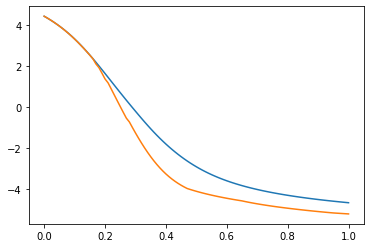

In [175]:
plt.plot(times_mc, energies_mc)
plt.plot(times, energies)

In [82]:
times, energies_gt3_lt5 = integrate(partial(sgd_dual, learning_rate=0.01, gradtol=1e-3, losstol=1e-5, maxiter=100), theta0, dt, T)

-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.
-- Reached losstol.


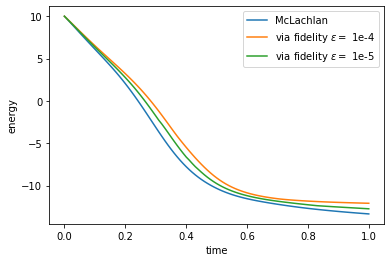

In [90]:
plt.plot(times_mc, energies_mc, label="McLachlan")
plt.plot(times, energies, label=r"via fidelity $\epsilon =$ 1e-4")
plt.plot(times, energies_gt3_lt5, label="via fidelity $\epsilon =$ 1e-5")
plt.xlabel("time")
plt.ylabel("energy")
plt.legend(loc="best")

In [ ]:
RealAmplitudes